<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка
Загрузите данные и выполните их ресемплирование по одному часу.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv(url, index_col=[0], parse_dates=[0])

In [3]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод
Загрузил библеотеки, данные, сделал ресемплирование по часу с суммой

## Анализ

In [4]:
df.info(), df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


(None,
         num_orders
 count  4416.000000
 mean     84.422781
 std      45.023853
 min       0.000000
 25%      54.000000
 50%      78.000000
 75%     107.000000
 max     462.000000)

In [5]:
df.index.is_monotonic

True

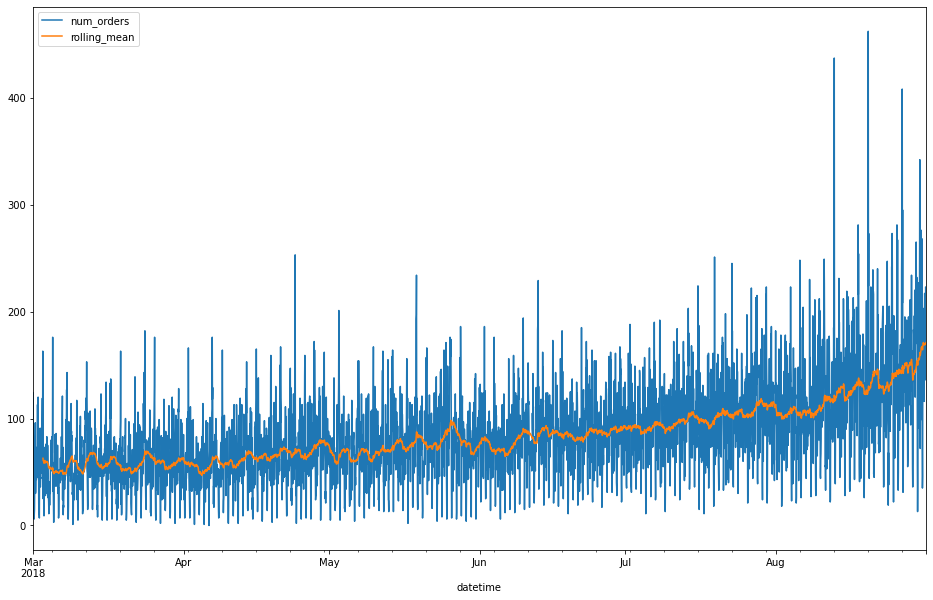

In [6]:
df['rolling_mean'] = df.rolling(50).mean() 
df.plot(figsize=(16, 10));

In [7]:
decomposed = seasonal_decompose(df['num_orders'])

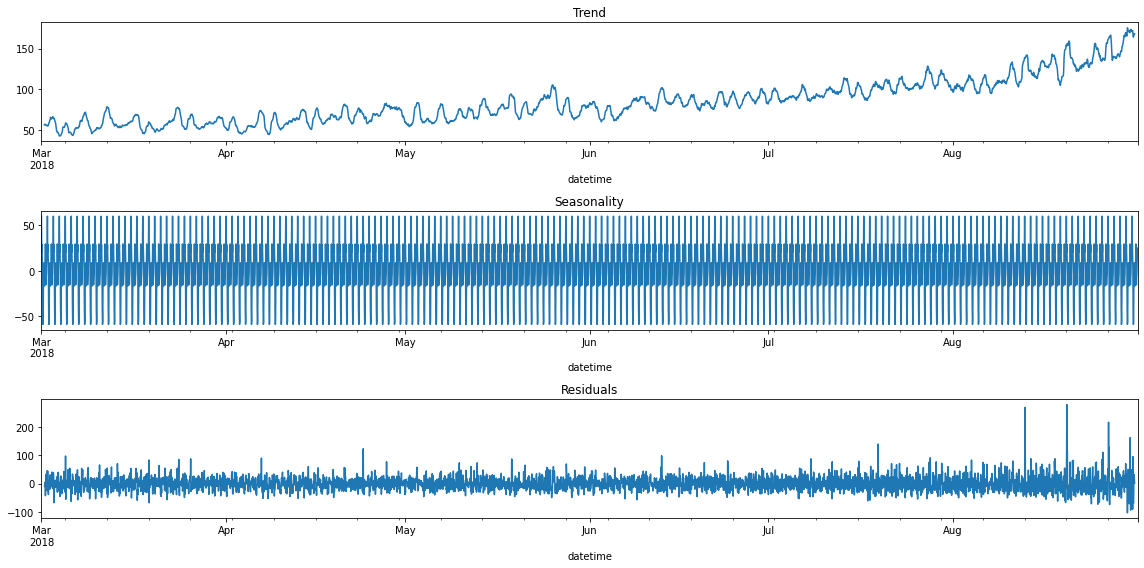

In [8]:
plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Есть растущий тренд

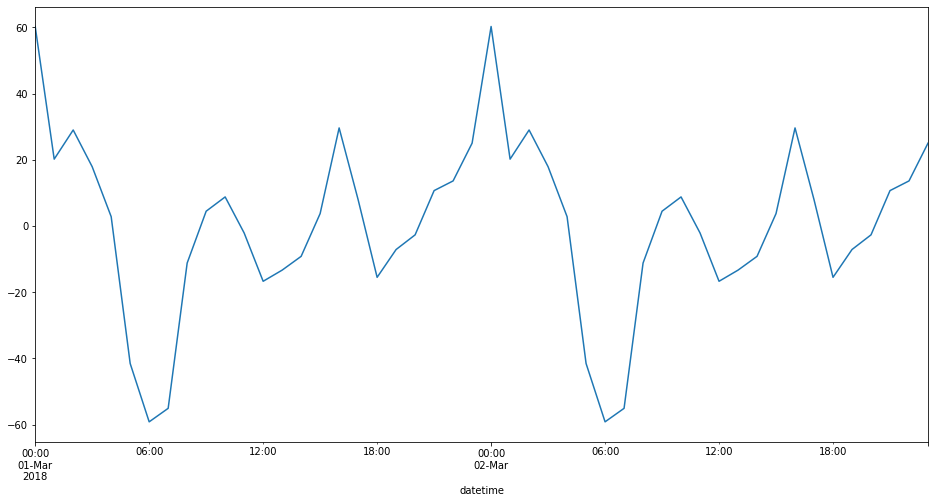

In [9]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(16, 8));

Сезонность дневная, с 24 часов до 6 часов наблюдается спад заказов с минимумом в 6 часов, с 18 часов до 24 часов наблюдается рост заказов с максимум в 24 часа.

## Обучение

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(df, 30, 50)
df = df.dropna()
df.head()

,num_orders,rolling_mean,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,62.82,2,3,3,5,108.0,163.0,72.0,119.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0
2018-03-03 03:00:00,64,60.84,3,3,3,5,25.0,108.0,163.0,72.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0
2018-03-03 04:00:00,44,60.42,4,3,3,5,64.0,25.0,108.0,163.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0
2018-03-03 05:00:00,15,59.88,5,3,3,5,44.0,64.0,25.0,108.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0
2018-03-03 06:00:00,9,58.86,6,3,3,5,15.0,44.0,64.0,25.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0


In [12]:
cat = ['hour', 'month', 'day', 'dayofweek']

In [13]:
X_train, X_test, y_train, test_y = train_test_split(df.drop('num_orders',axis=1),
                                                    df['num_orders'], 
                                                    test_size=0.1, shuffle=False,
                                                    random_state=1234)

In [14]:
cat_model = CatBoostRegressor(random_state=1234, cat_features=cat)

parameters =  {'loss_function':['RMSE'],
              "n_estimators": [200, 400],
              "verbose": [200],
              "learning_rate": [0.03, 0.1]}

grid_cat_model = GridSearchCV(cat_model, param_grid=parameters, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5), verbose=True)
grid_cat_model.fit(X_train, y_train)


grid_cat_model.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 28.8787192	total: 54.4ms	remaining: 10.8s
199:	learn: 13.2919044	total: 1.05s	remaining: 0us
0:	learn: 29.9252172	total: 11.2ms	remaining: 2.22s
199:	learn: 15.5143074	total: 1.24s	remaining: 0us
0:	learn: 31.6660704	total: 9.17ms	remaining: 1.82s
199:	learn: 16.5390886	total: 1.67s	remaining: 0us
0:	learn: 32.8953161	total: 10.4ms	remaining: 2.07s
199:	learn: 17.5588581	total: 1.76s	remaining: 0us
0:	learn: 34.2825905	total: 10.8ms	remaining: 2.14s
199:	learn: 18.7225954	total: 1.92s	remaining: 0us
0:	learn: 28.8787192	total: 5.38ms	remaining: 2.15s
200:	learn: 13.2558618	total: 1.04s	remaining: 1.03s
399:	learn: 9.8990842	total: 2.09s	remaining: 0us
0:	learn: 29.9252172	total: 9.5ms	remaining: 3.79s
200:	learn: 15.4954374	total: 1.26s	remaining: 1.25s
399:	learn: 12.7617241	total: 2.49s	remaining: 0us
0:	learn: 31.6660704	total: 8.15ms	remaining: 3.25s
200:	learn: 16.5272874	total: 1.55s	remaining: 1.54s
399:	learn

{'learning_rate': 0.03,
 'loss_function': 'RMSE',
 'n_estimators': 400,
 'verbose': 200}

In [ ]:
lgbm_model = LGBMRegressor(random_state=1234)

parameters =  {
              "n_estimators": [200, 400],
              "verbose": [200],
              "learning_rate": [0.03, 0.1]}

grid_lgbm_model = GridSearchCV(lgbm_model, param_grid=parameters, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5), verbose=True)
grid_lgbm_model.fit(X_train, y_train, categorical_feature=cat)


grid_lgbm_model.best_params_

## Тестирование

In [16]:
pred = grid_cat_model.predict(X_test)
mean_squared_error(pred, test_y) ** 0.5

42.157782519590505

In [17]:
pred = grid_lgbm_model.predict(X_test)
mean_squared_error(pred, test_y) ** 0.5

41.524879746576595

In [18]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
pred = linear_model.predict(X_test)
mean_squared_error(pred, test_y) ** 0.5

45.9613036533796

## Тестирование
Удалось добиться RMSE меньше 48, имея данные о количестве поездак можно добится хорошей точности предсказания будущих заказов, catboost долго учиться, лучше использовать lgbm.